# AWS Bedrock Integration

This notebook aims to provide an example of how to access [Bedrock](https://docs.aws.amazon.com/bedrock/latest/userguide/what-is-bedrock.html) and call one of their hosted LLMs.

The LLM of this example is an Anthropic Claude model, and we are going to simulate a virtual assistant.

## Pre-requisites

In order to interact with AWS Bedrock, you need to configure authentication first. 

Follow [these instructions](https://github.com/elastic/cloud/blob/master/wiki/AWS.md#configuring-okta-awscli-for-cli--api-access) in order to do so. You will need a Yubikey to enable MFA.

## Example

The first thing we need to do is to create the Bedrock runtime client:

In [1]:
from ml_utils.aws.bedrock.bedrock_clients import get_bedrock_runtime_client

bedrock_runtime_client = get_bedrock_runtime_client()

Let's define now some initial parameters:

In [2]:
model_id = "anthropic.claude-3-sonnet-20240229-v1:0"
system_prompt = "Please respond only with emoji."
max_tokens = 1000

Let's invoke the model with an initial prompt:

In [3]:
user_message = {"role": "user", "content": "Hello there! How are you doing today?"}
messages = [user_message]

In [4]:
import json

from botocore.exceptions import ClientError

try:
    body = json.dumps(
        {
            "anthropic_version": "bedrock-2023-05-31",
            "max_tokens": max_tokens,
            "system": system_prompt,
            "messages": messages,
        }
    )

    response = bedrock_runtime_client.invoke_model(body=body, modelId=model_id)
    response_body = json.loads(response["body"].read())
    print(response_body)

except ClientError as e:
    message = e.response["Error"]["Message"]
    print(f"A client error occurred: {message}")

{'id': 'msg_bdrk_01WA5jsPx9a7aykajWHaGurB', 'type': 'message', 'role': 'assistant', 'model': 'claude-3-sonnet-20240229', 'content': [{'type': 'text', 'text': '👋🙂'}], 'stop_reason': 'end_turn', 'stop_sequence': None, 'usage': {'input_tokens': 22, 'output_tokens': 9}}


To check the different models and options that you have at hand with Bedrock, check [this chapter](https://docs.aws.amazon.com/bedrock/latest/userguide/model-parameters.html) of the documentation.

To check the pricing of each inference, see the [pricing information](https://aws.amazon.com/bedrock/pricing/).

Check [here](https://docs.aws.amazon.com/bedrock/latest/userguide/models-regions.html) the models supported by region.

And, finally, check [here](https://docs.aws.amazon.com/bedrock/latest/userguide/conversation-inference.html) the Converse API, which is more intended for conversations.

## Optional: Store the result of MLflow

You can use MLflow to track your prompts and responses.

First, connect to our centralized MLflow server:

In [5]:
from ml_utils.aws.sagemaker import authenticate_in_aws_sagemaker
from ml_utils.mlflow.server import set_mlflow_server

authenticate_in_aws_sagemaker()
set_mlflow_server()

2025-02-19 12:35:00.100 | INFO     | ml_utils.aws.sagemaker:authenticate_in_aws_sagemaker:14 - Authenticating to AWS Sagemaker...
2025-02-19 12:35:01.195 | INFO     | ml_utils.aws.sagemaker:authenticate_in_aws_sagemaker:23 - Authentication to AWS Sagemaker successfully done!
2025-02-19 12:35:01.196 | INFO     | ml_utils.mlflow.server:set_mlflow_server:13 - MLflow Tracking Server set to arn:aws:sagemaker:us-east-1:879381254630:mlflow-tracking-server/ml-rd-mlflow-server


Now, let's log the input prompt and the response we got:

In [6]:
import mlflow

mlflow.set_experiment("mvp-mlops-platform")

<Experiment: artifact_location='s3://ml-rd-mlflow-artifact-storage/artifacts/39', creation_time=1736873360807, experiment_id='39', last_update_time=1736873360807, lifecycle_stage='active', name='mvp-mlops-platform', tags={'mlflow.note.content': 'This is a test experiment',
 'release.version': '2.2.0',
 'use-case': 'mvp-mlops'}>

In [7]:
with mlflow.start_run(run_name="bedrock-emoji-example"):
    mlflow.log_text(text=system_prompt, artifact_file="system_prompt.txt")
    mlflow.log_text(text=json.dumps(user_message), artifact_file="user_message.json")
    mlflow.log_text(text=json.dumps(response_body), artifact_file="response.json")

2025/02/19 12:35:04 INFO mlflow.tracking._tracking_service.client: 🏃 View run bedrock-emoji-example at: https://us-east-1.experiments.sagemaker.aws/#/experiments/39/runs/a46ad34573e8475b95b19bce64034042.
2025/02/19 12:35:04 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://us-east-1.experiments.sagemaker.aws/#/experiments/39.


Now go and check the results of the mlflow UI:

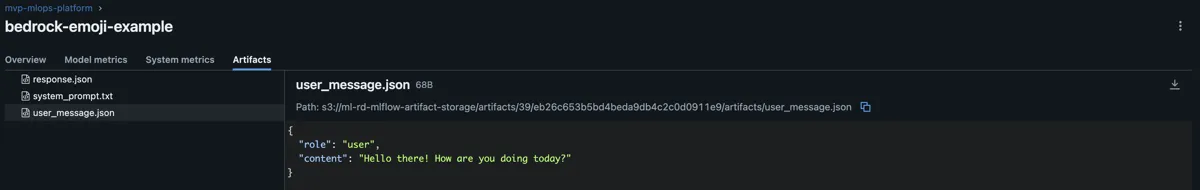

In [10]:
from IPython.display import Image

Image(filename="images/mlflow_bedrock_user.webp")

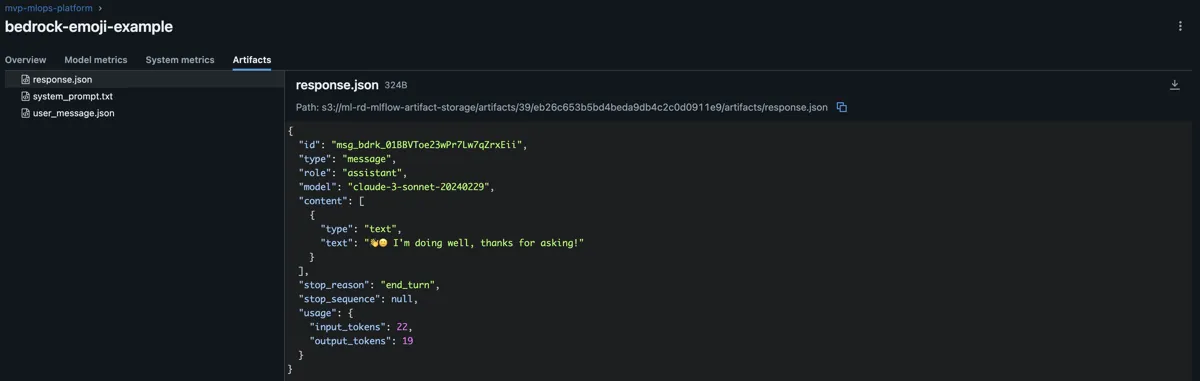

In [11]:
from IPython.display import Image

Image(filename="images/mlflow_llm_response.webp")